In [1]:
import numpy as np
import pandas as pd
import tsfel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from dataclasses import dataclass
import os
import matplotlib.ticker as mticker
import pickle
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Task-4 Data Collection in the Wild**

Q1. Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform?

In [2]:
X_train = np.load('../Datasets/Manual Data/X_train.npy')
X_test = np.load('../Datasets/Manual Data/X_test.npy')
y_train = np.load('../Datasets/Manual Data/y_train.npy')
y_test = np.load('../Datasets/Manual Data/y_test.npy')
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(18, 500, 3)

(6, 500, 3)

(18,)

(6,)

In [3]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

X_reshaped = np.concatenate((X_train_reshaped, X_test_reshaped), axis=0)
y_reshaped = np.concatenate((y_train, y_test), axis=0)

display(X_reshaped[:5])
display(y_reshaped)

array([[ 0.1412,  0.9897,  0.0078, ...,  0.15  ,  0.9941,  0.0117],
       [ 0.0059,  1.0044, -0.0356, ...,  0.0054,  1.0014, -0.0361],
       [-0.0439,  0.9971,  0.0073, ..., -0.0156,  0.9883,  0.0137],
       [ 1.0085,  0.2133,  0.0112, ...,  0.9963,  0.2392,  0.0142],
       [ 0.9464,  0.3017,  0.0865, ...,  1.0256,  0.1444,  0.0689]],
      shape=(5, 1500))

array(['LAYING', 'LAYING', 'LAYING', 'SITTING', 'SITTING', 'SITTING',
       'STANDING', 'STANDING', 'STANDING', 'WALKING_DOWNSTAIRS',
       'WALKING_DOWNSTAIRS', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS',
       'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING', 'WALKING',
       'WALKING', 'LAYING', 'SITTING', 'STANDING', 'WALKING',
       'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'], dtype='<U18')

In [4]:
with open('../Task-3 Data Collection in the Wild/Saved_DecisionTrees/dt1_model.sav', 'rb') as f:
    dt1 = pickle.load(f)
print(type(dt1))

with open('../Task-3 Data Collection in the Wild/Saved_DecisionTrees/dt2_model.sav', 'rb') as f:
    dt2 = pickle.load(f)
print(type(dt2))

with open('../Task-3 Data Collection in the Wild/Saved_DecisionTrees/dt3_model.sav', 'rb') as f:
    dt3 = pickle.load(f)
print(type(dt3))

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>


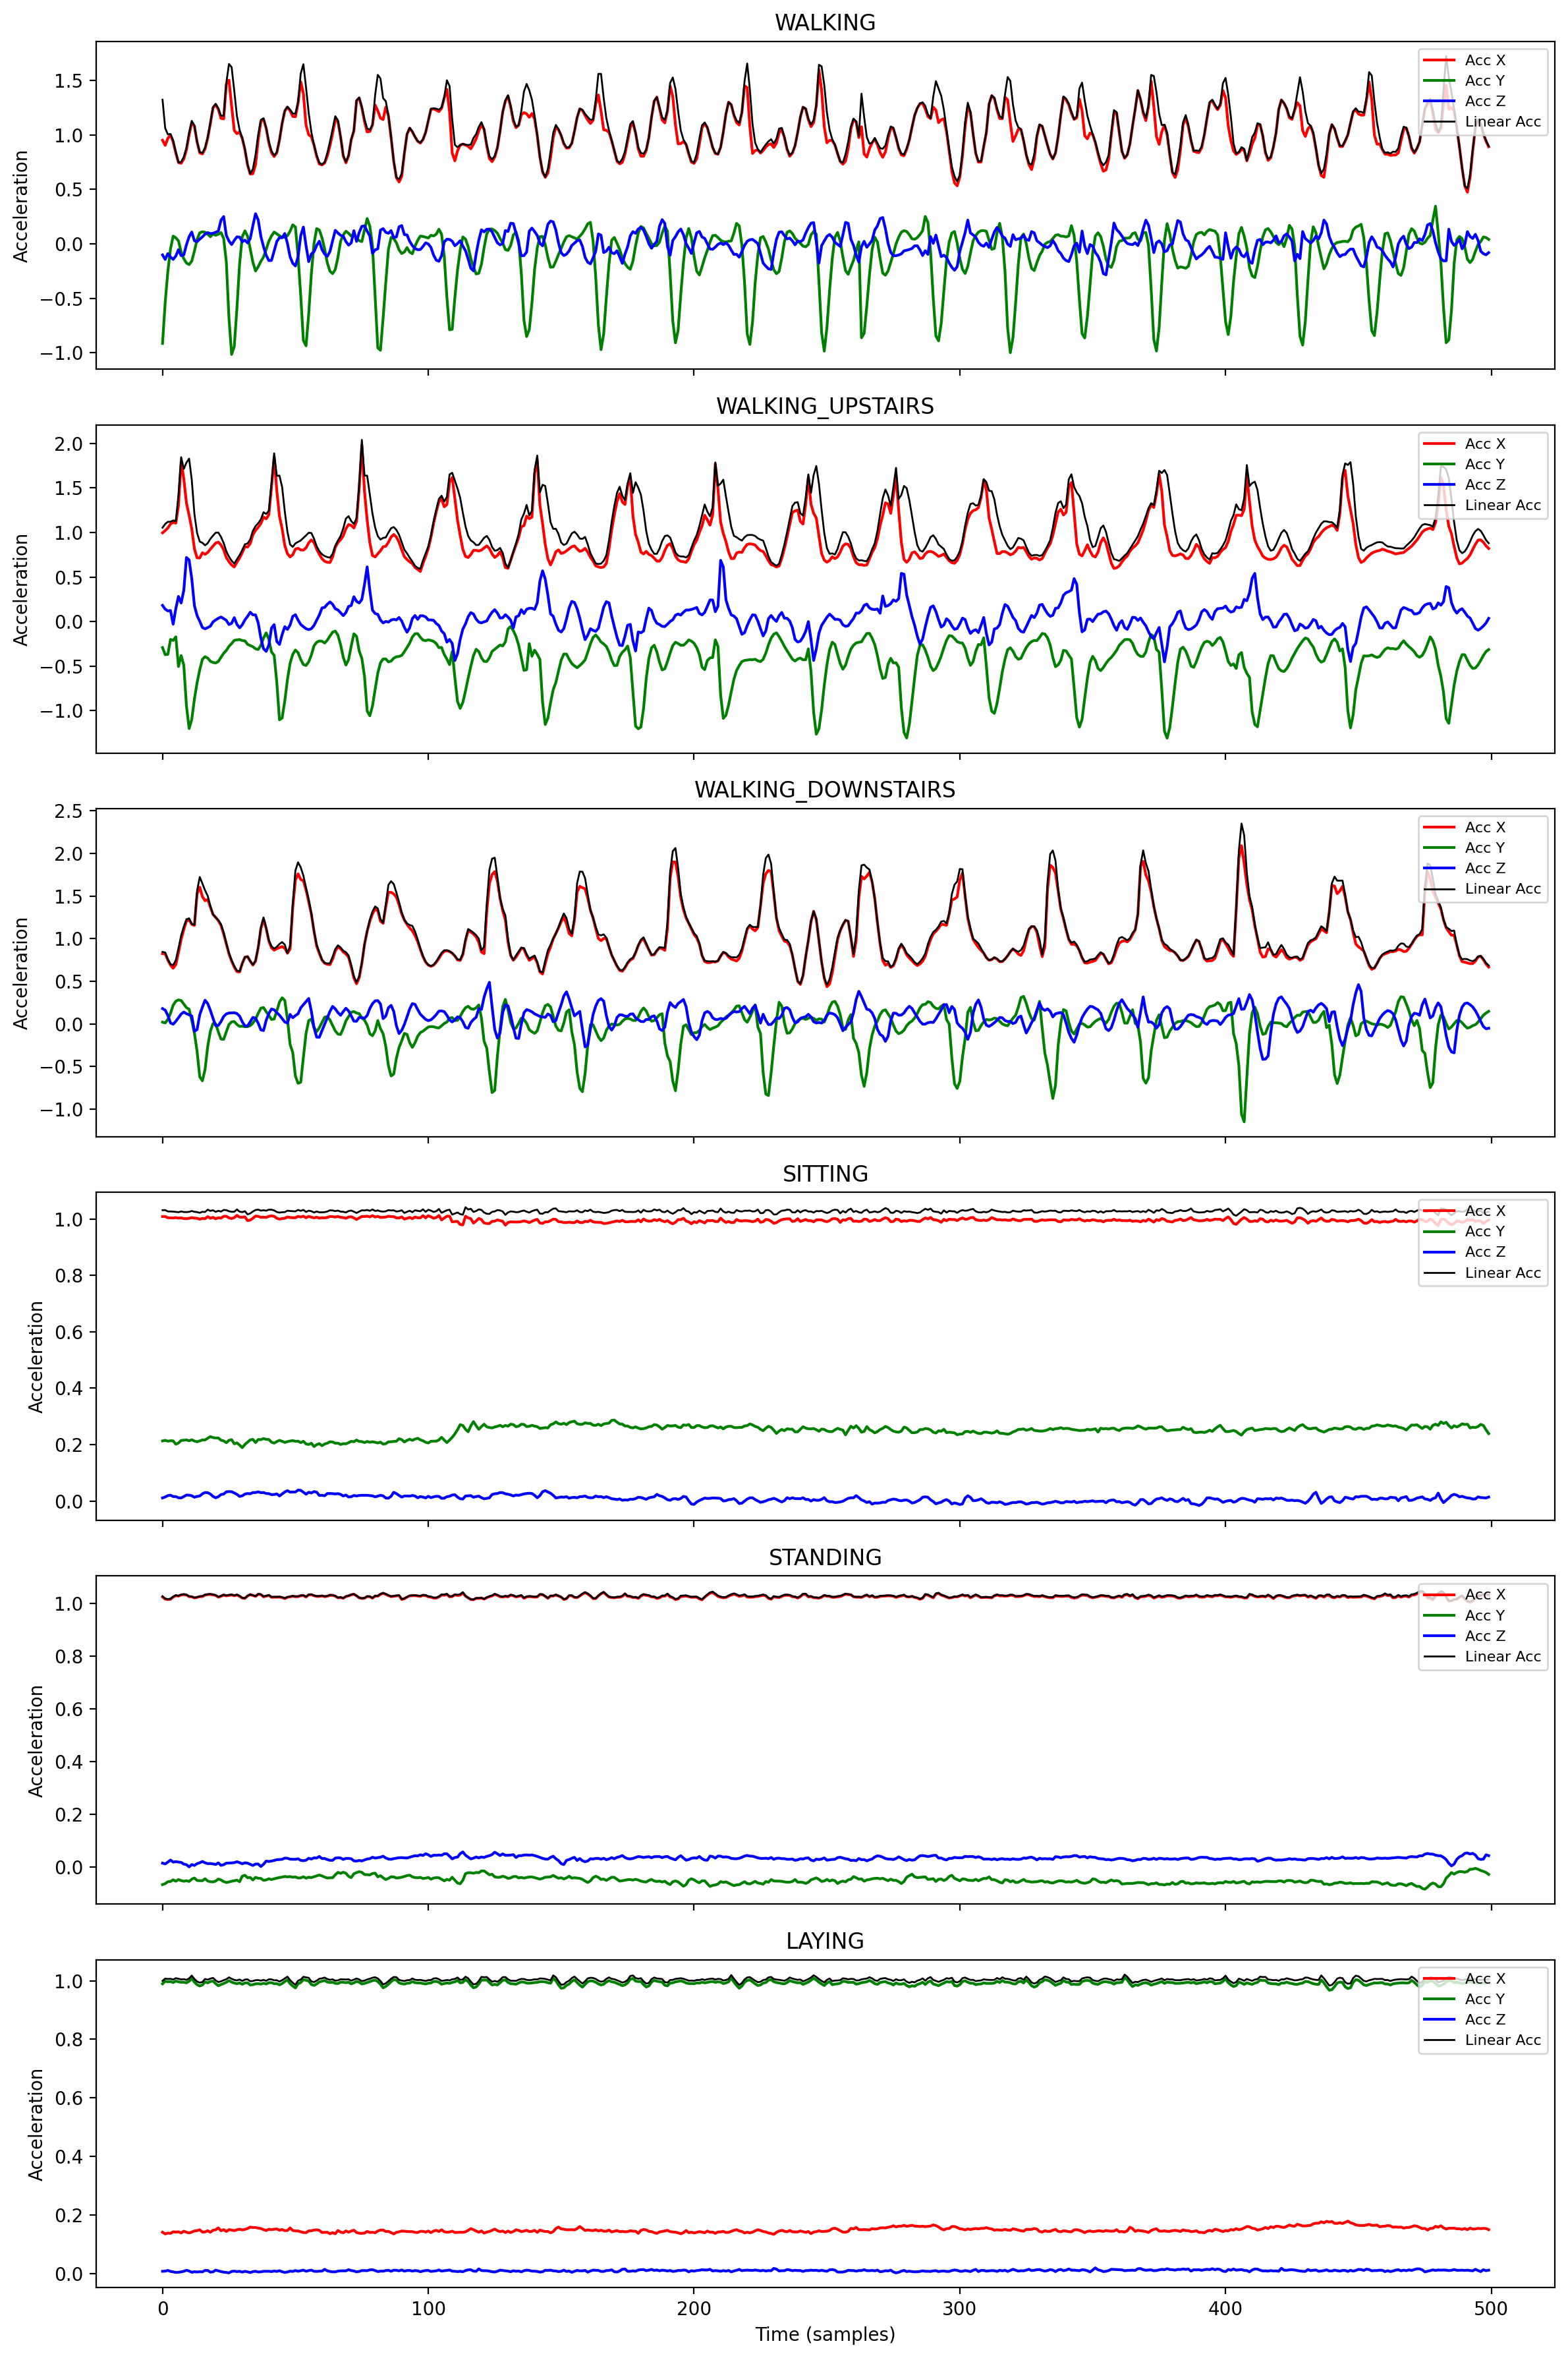

In [5]:
# activity classes (kept just for order)
classes = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

activity_samples = {}

# choose one sample per activity
for _, activity_name in classes.items():
    idx = np.where(y_reshaped == activity_name)[0][0]   # match string label
    activity_samples[activity_name] = X_reshaped[idx]

# create subplots (one row per activity)
fig, axes = plt.subplots(len(activity_samples), 1, figsize=(12, 18), sharex=True)

for ax, (activity_name, sample) in zip(axes, activity_samples.items()):
    sample = np.array(sample)
    if sample.ndim == 1:
        sample = sample.reshape(-1, 3)
    
    # linear acceleration magnitude
    linear_acc = np.linalg.norm(sample, axis=1)  
    
    # plot x, y, z
    ax.plot(sample[:, 0], label='Acc X', color='red')
    ax.plot(sample[:, 1], label='Acc Y', color='green')
    ax.plot(sample[:, 2], label='Acc Z', color='blue')
    ax.plot(linear_acc, label='Linear Acc', color='black', linewidth=1)
    
    ax.set_title(activity_name)
    ax.set_ylabel("Acceleration")
    ax.legend(loc="upper right", fontsize=8)

axes[-1].set_xlabel("Time (samples)")
plt.tight_layout()
plt.show()


### Here train data is the Raw Accelerometer Decision Tree

In [6]:
y_dt1_pred = dt1.predict(X_reshaped)

# map numeric predictions -> string labels
y_dt1_pred_str = np.array([classes[num] for num in y_dt1_pred])

# now both arrays are string labels
y_combined = np.array(y_reshaped)
y_dt1_pred = y_dt1_pred_str

# Calculate metrics
accuracy = accuracy_score(y_combined, y_dt1_pred)
precision = precision_score(y_combined, y_dt1_pred, average='macro')
recall = recall_score(y_combined, y_dt1_pred, average='macro')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

# Create and display comparison DataFrame
comparison_df = pd.DataFrame({
    'True Label': y_combined,
    'Predicted Label': y_dt1_pred
})
print(comparison_df.head())


Accuracy:  0.5416666666666666
Precision:  0.5793650793650793
Recall:  0.5416666666666666
  True Label Predicted Label
0     LAYING          LAYING
1     LAYING          LAYING
2     LAYING          LAYING
3    SITTING         SITTING
4    SITTING         SITTING


In [8]:
X_combined = np.concatenate((X_train, X_test), axis=0)

# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_dt2 = tsfel.time_series_features_extractor(cfg, X_combined, verbose=1, fs=50)

print(f"X: {X_dt2.shape}")
print(f"y: {y_combined.shape}")

X: (24, 468)
y: (24,)


### Here train data is of the TSFEL Decision Tree

In [9]:
y_dt2_pred = dt2.predict(X_dt2)

# map numeric predictions -> string labels
y_dt2_pred_str = np.array([classes[num] for num in y_dt2_pred])

# now both arrays are string labels
y_combined = np.array(y_combined)   # already strings
y_dt2_pred = y_dt2_pred_str

# Calculate metrics
accuracy = accuracy_score(y_combined, y_dt2_pred)
precision = precision_score(y_combined, y_dt2_pred, average='macro')
recall = recall_score(y_combined, y_dt2_pred, average='macro')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

# Create and display comparison DataFrame
comparison_df = pd.DataFrame({
    'True Label': y_combined,
    'Predicted Label': y_dt2_pred
})

# Display the DataFrame
print(comparison_df.head())


Accuracy:  0.6666666666666666
Precision:  0.6888888888888888
Recall:  0.6666666666666666
  True Label Predicted Label
0     LAYING          LAYING
1     LAYING          LAYING
2     LAYING          LAYING
3    SITTING        STANDING
4    SITTING         SITTING


c:\Users\siddh\OneDrive - iitgn.ac.in\ML\ML_venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Q2. Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform?

In [10]:
X_train_stacked=np.hstack((X_train[:,:,0],X_train[:,:,1],X_train[:,:,2]))
X_test_stacked=np.hstack((X_test[:,:,0],X_test[:,:,1],X_test[:,:,2]))

print(f"X_train_stacked: {X_train_stacked.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {X_test_stacked.shape}")
print(f"y_test: {y_test.shape}")

dt1_=DecisionTreeClassifier(random_state=42)
dt1_.fit(X_train_stacked,y_train)

y_pred_dt1=dt1_.predict(X_test_stacked)

print("Accuracy: ",accuracy_score(y_test, y_pred_dt1))
print("Precision: ",precision_score(y_test, y_pred_dt1,average='macro'))
print("Recall: ",recall_score(y_test, y_pred_dt1,average='macro'))

X_train_stacked: (18, 1500)
y_train: (18,)
x_test: (6, 1500)
y_test: (6,)
Accuracy:  0.5
Precision:  0.4166666666666667
Recall:  0.5


c:\Users\siddh\OneDrive - iitgn.ac.in\ML\ML_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train, verbose=1,fs =50)
X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test, verbose=1,fs =50)

print(f"X_train_tsfel: {X_train_tsfel.shape}")
print(f"X_test_tsfel: {X_test_tsfel.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train_tsfel, threshold=0.95)
X_train_tsfel.drop(corr_features, axis=1, inplace=True)
X_test_tsfel.drop(corr_features, axis=1, inplace=True)
print("Shape of train data after removing correlated features:",X_train_tsfel.shape)
print("Shape of test data after removing correlated features:",X_test_tsfel.shape)

# Remove low variance features
selector = VarianceThreshold(threshold = 0.1) # default is 0
X_train_tsfel = selector.fit_transform(X_train_tsfel)
X_test_tsfel = selector.transform(X_test_tsfel)
print("\nShape of train data after removing low variance features:",X_train_tsfel.shape)
print("Shape of test data after removing low variance features:",X_test_tsfel.shape)

# Normalising Features
scaler = StandardScaler()
X_train_tsfel_scaled = scaler.fit_transform(X_train_tsfel)
X_test_tsfel_scaled = scaler.transform(X_test_tsfel)

# Applying PCA
tsfel_pca = PCA(n_components=5)
X_train_tsfel_pca = tsfel_pca.fit_transform(X_train_tsfel_scaled)
X_test_tsfel_pca = tsfel_pca.transform(X_test_tsfel_scaled)

print("Training data shape after PCA: ",X_train_tsfel_pca.shape)
print("Testing data shape after PCA: ",X_test_tsfel_pca.shape)

X_train_tsfel: (18, 468)
X_test_tsfel: (6, 468)
y_train: (18,)
y_test: (6,)
Shape of train data after removing correlated features: (18, 221)
Shape of test data after removing correlated features: (6, 221)

Shape of train data after removing low variance features: (18, 89)
Shape of test data after removing low variance features: (6, 89)
Training data shape after PCA:  (18, 5)
Testing data shape after PCA:  (6, 5)


In [12]:

dt3_=DecisionTreeClassifier(random_state=42)
dt3_.fit(X_train_tsfel_pca,y_train)

y_tsfel_pca_pred=dt3_.predict(X_test_tsfel_pca)

print("Accuracy: ",accuracy_score(y_test, y_tsfel_pca_pred))
print("Precision: ",precision_score(y_test, y_tsfel_pca_pred,average='macro'))
print("Recall: ",recall_score(y_test, y_tsfel_pca_pred,average='macro'))

Accuracy:  0.6666666666666666
Precision:  0.5555555555555556
Recall:  0.6666666666666666


c:\Users\siddh\OneDrive - iitgn.ac.in\ML\ML_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
